<a href="https://colab.research.google.com/github/filopacio/_python_4_analytics_nlp_project/blob/main/ebola_vs_covid_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---
## Comparing and contrasting ebola and covid spreading of information on Twitter
---

This project is a NLP analysis of Twitter.

Tweets related to COVID and EBOLA have been analysed in order to find, if any, some patterns in the spreading of news.

The research is mainly descriptive and focuses on two main different but actually interrelated themes:

- Sentiment Analysis.
Sentiments, initially labelled only as POSITIVE or NEGATIVE and then also analysed through more complex sentiments/emotions have been assigned to tweets and analysed. 

- Use Of Keywords.
Tweets have been processed in order to extrapolate the most commonly adopted words or expressions. The recurrence of words has been analysed also in relation to sentiments.


In [161]:
#!pip install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
!pip install -qq twint
!pip install nest_asyncio
!pip install text2emotion

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nest_asyncio
import twint 
from matplotlib import pyplot as plt

## Scrape tweets 

The package twint allows to scrape tweets without the need of API. 

Unfortunately the queries' commands were sometimes inconsistent and so some ex-post data selection and cleaning was necessary.

**Query for "covid"**


The period taken into consideration for COVID was from $1^{st}$ January 2020 to $30^{th}$ June 2021

In [ ]:
from datetime import datetime, timedelta

In [ ]:
d0 = datetime(2020, 1, 1)
d1 = datetime(2021, 6, 30)
dt = timedelta(days = 4)
dates = np.arange(d0, d1, dt).astype(datetime)

df_c = pd.DataFrame()

nest_asyncio.apply()
for i in dates:
  c = twint.Config()
  c.Search = 'covid'
  c.Until  = "{}".format(i)
  c.Lang = "en"
  c.Pandas = True
  c.Limit = 1000
  # Run
  twint.run.Search(c)
  df_c = df_c.append(twint.storage.panda.Tweets_df[['date', 'tweet','language' ,'username', 'nlikes', 'nretweets']])
  df_c.date = pd.to_datetime(df_c.date)
  df_c = df_c[df_c.language == 'en']
  df_c = df_c[df_c.date >= datetime(2020,1,1)]
  df_c.to_csv('df_c.csv')

In [ ]:
from google.colab import files

In [ ]:
files.download("df_c.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Query for "ebola"**

In [ ]:
d0 = datetime(2014, 7, 1)
d1 = datetime(2015, 5, 31)
dt = timedelta(days = 1)
dates = np.arange(d0, d1, dt).astype(datetime)

nest_asyncio.apply()
df_e = pd.DataFrame()
for i in dates:
  e = twint.Config()
  e.Search = 'ebola'
  e.Until  = "{}".format(i)
  e.Lang = "en"
  e.Pandas = True
  e.Limit = 1000
  # Run
  twint.run.Search(e)
  df_e = df_e.append(twint.storage.panda.Tweets_df[['date', 'tweet','language' ,'username', 'nlikes', 'nretweets']])
  df_e.date = pd.to_datetime(df_e.date)
  df_e = df_e[df_e.language == 'en']
  df_e = df_e[df_e.date >= datetime(2014,3,1)]
  df_e = df_e[df_e.date <= datetime(2015,5,31)]
  df_e.to_csv('df_e')

In [ ]:
files.download("df_e.csv")

FileNotFoundError: ignored

Since both the queries are huge (millions of tweets) I  divided them into a  series of smaller queries for computational reason. I retrieved around 1000 tweets every 2 day inside the selected periods, so that the computation was not infeasible but still my sample was large and heterogenous enough. 


Also, some selection  and slicing of final data has been done while the loop was still running in order to reduce memory capacity and computational efforts. 


Finally, at every cycle of the loop I saved the resulting .csv file so that, in case of sudden stop of scraping, data up to that moment could be saved. 

##Upload Datasets

In [173]:
import csv

In [174]:
with open('df_c.csv') as c:
    reader = csv.reader(c)
    l_c = list(reader)

df_c = pd.DataFrame(l_c, columns = ['','date', 'tweet','language' ,'username', 'nlikes', 'nretweets'])[1:].dropna().reset_index()

In [176]:
df_c.head()

,index,,date,tweet,language,username,nlikes,nretweets
0,1,0,2019-12-29 05:21:25,@ross_robertross @LateRoundCorner Lamar gonna ...,en,Racist_Covid,0,0
1,2,11,2019-12-28 23:28:59,@CaslerNoel @DonaldJTrumpJr @realDonaldTrump @...,en,COVID_Careful,0,0
2,3,12,2019-12-28 23:23:01,@realDonaldTrump You do realize SF is part of ...,en,COVID_Careful,0,0
3,4,15,2019-12-28 22:16:08,I got a new mullet 🙊🙊 https://t.co/a6TBWBexG8,en,covid_mullet,45,5
4,5,17,2019-12-28 21:35:16,@IDreamOfNinja Danny needs help. I refuse to h...,en,covid_longhaul,2,0


In [171]:
with open("df_e.csv") as e:
    reader = csv.reader(e)
    l_e = list(reader)
    
df_e = pd.DataFrame(l_e, columns = ['','date', 'tweet','language' ,'username', 'nlikes', 'nretweets'])[1:].dropna().reset_index()

In [172]:
df_e.head()

67929

## Sentiment Labelling

To compute the sentiments I used the Vader Sentiment Analyzer from the nltk package. 

It allows to compute very fast sentiment analysis. The output of the function is a dictionary containing the polarities of the three main sentiments:
- Positive
- Negative
- Neutral


Also, it returns a quantity named 'compound' which is the normalized sum of the 3 quantities.


In [177]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [178]:
sent_analyzer = SentimentIntensityAnalyzer()

In [179]:
c = [sent_analyzer.polarity_scores(i) for i in df_c.tweet]
e = [sent_analyzer.polarity_scores(i) for i in df_e.tweet]

In [180]:
df_c['polarity'] = [i.get('compound') for i in c]
df_e['polarity'] = [i.get('compound') for i in e]

Let's now label the tweets as 'positive', 'negative or 'neutral' based on values of the compound. Let's start with an heaven splitting into three parts. 

In [181]:
df_c['sentiment'] = np.repeat(1,len(df_c))
for i in range(len(df_c)):
   if df_c.polarity[i] > 1/3:
     df_c['sentiment'][i] = 'positive'
   elif df_c.polarity[i] < -1/3:
        df_c['sentiment'][i] = 'negative'
   else:
        df_c['sentiment'][i] = 'neutral'

df_c.sentiment

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py

0        negative
1         neutral
2        positive
3         neutral
4        positive
           ...   
80866    positive
80867    positive
80868    positive
80869    positive
80870    positive
Name: sentiment, Length: 80871, dtype: object

(array([22961.,     0.,     0.,     0.,     0., 35290.,     0.,     0.,
            0., 22620.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

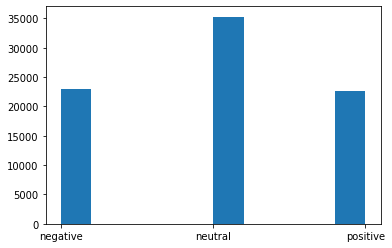

In [182]:
plt.hist(df_c.sentiment)

In [183]:
df_e['sentiment'] = np.repeat(1,len(df_e))
for i in range(len(df_e)):
   if df_e.polarity[i] > 1/3:
     df_e['sentiment'][i] = 'positive'
   elif df_e.polarity[i] < -1/3:
        df_e['sentiment'][i] = 'negative'
   else:
        df_e['sentiment'][i] = 'neutral'

df_e.sentiment

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py

0        negative
1         neutral
2        positive
3        negative
4        negative
           ...   
67924    positive
67925     neutral
67926     neutral
67927    negative
67928     neutral
Name: sentiment, Length: 67929, dtype: object

(array([18185.,     0.,     0.,     0.,     0., 37907.,     0.,     0.,
            0., 11837.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

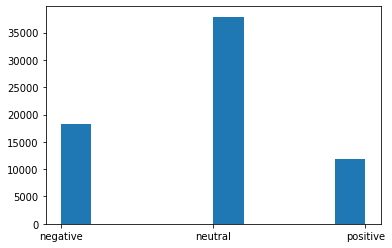

In [184]:
plt.hist(df_e.sentiment)

Vader's sentiment analyzer is pretty cautious, therefore it is likely not to take extremely polarized values. Consequently, under this splitting of data, the vast majority of tweets are labelled as neutral.

So let's see what happens if the 'neutral' label is removed, letting the sentiments be either 'positive' or 'negative' based, respectively, on positive or negative values of the compound.

In [185]:
sen = list(np.repeat(1,len(df_c)))
for i in range(len(df_c)):
   if df_c.polarity[i] > 0:
     sen[i] = 'positive'
   else:
    sen[i] = 'negative'

(array([50114.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 30757.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

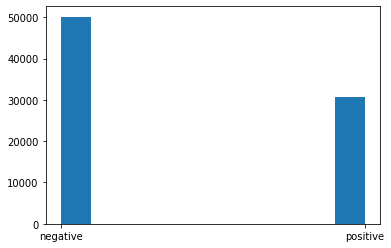

In [186]:
plt.hist(sen)

In [187]:
sen = list(np.repeat(1,len(df_e)))
for i in range(len(df_e)):
   if df_e.polarity[i] > 0:
     sen[i] = 'positive'
   else:
    sen[i] = 'negative'

(array([50954.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 16975.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

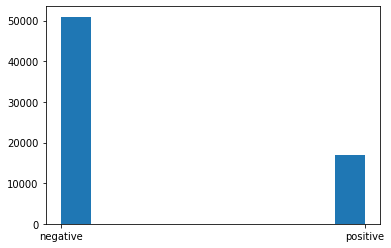

In [188]:
plt.hist(sen)

From those histograms more meaningful result are obtained. As expected, tweets related both to covid and ebola are, on average, much more negative than positive. 

## Preprocessing


In [189]:
import re
import string
import nltk
from nltk.corpus import stopwords
from itertools import chain
from nltk.stem.porter import PorterStemmer 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Text Cleaning**

I created the clean_text function in order to clean the tweets from noisy characters. 

items removed: 
- links
- punctuations/special characters 
- emoticons

Before doing so I also put all the texts in lower case.
I did not remove alphanumeric words to avoid eliminating words like covid19, covid-19 etc.

In [190]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('https://\S+|www\.\S', '', text)      # remove link
    text = re.sub("['!@#$%^&*()_+<>?:.,;]" , '', text)  # punctuations/special characters
    text = re.sub(re.compile("["                        # emoticon
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
                           "]+", flags=re.UNICODE), '', text)
    return text

After being cleaned, each tweet is splitted into single words. 
Therefore, 'words' is a list of lists, where each element is a list of separated strings. 
Now, other pre-processing actions will be performed. 

**Stopwords removal**

What is considered a stopword can be found in the set  below. Such list belongs to the package nltk. 

In [191]:
stopwords = set(stopwords.words('english')) 
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [192]:
def remove_stopwords(text):
    stop = set(stopwords.words('english'))  
    stop.add('im')
    stop.add("i'm")
    stop.add('could')
    stop.add('go')
    stop.add('it')
    stop.add('get')
   # not present in the original set but very recurrent words
    text = [[i for i in i.split() if i not in stop] for i in text]
    return  text

**Lemmatization**

In [193]:
def lemmatize(text):
    lem = WordNetLemmatizer()
    corpus = [[lem.lemmatize(i, pos = 'v') for i in i] for i in text]
    return text

**Stemming**

In [194]:
def sb_stem(text):
   stemmer = SnowballStemmer(language = 'english')
   text = [stemmer.stem(i) for i in text]
   return text

In [195]:
def p_stem(text):
   stemmer = PorterStemmer()
   text = [stemmer.stem(i) for i in text]
   return text

**Final outcome of preprocessing**

In [196]:
def preprocess(text):
  cl_tweets = [clean_text(c) for c in text]
  cl_tweets = pd.Series(cl_tweets).astype(str)
  removed = remove_stopwords(cl_tweets) 
  lemmatized = [lemmatize(i) for i in removed]
  #stemmed = [p_stem(i) for i in lemmatized]
  return lemmatized #stemmed

In [197]:
from nltk.corpus import stopwords

In [198]:
df_c['tweets'] = preprocess(df_c.tweet)

In [199]:
df_e['tweets'] = preprocess(df_e.tweet)

## Analysis of keywords

Let us now create an even more polarized situation.

Let's take only the most polarized positive and  negative tweets in order to find (if any) differences and similarities in the use of most common words between very positive and very negative tweets.

In [200]:
df_c['polarized_sen'] = np.repeat(1,len(df_c))
for i in range(len(df_c)):
   if df_c.polarity[i] > 0.5:
     df_c['polarized_sen'][i] = 'positive'
   elif df_c.polarity[i] < -0.5:
        df_c['polarized_sen'][i] = 'negative'
   else:
        df_c['polarized_sen'][i] = 'neutral'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py

In [201]:
df_e['polarized_sen'] = np.repeat(1,len(df_e))
for i in range(len(df_e)):
   if df_e.polarity[i] > 0.5:
     df_e['polarized_sen'][i] = 'positive'
   elif df_e.polarity[i] < -0.5:
        df_e['polarized_sen'][i] = 'negative'
   else:
        df_e['polarized_sen'][i] = 'neutral'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py

In [202]:
df_c_neg = df_c[df_c.polarized_sen == 'negative'].reset_index()
df_c_pos = df_c[df_c.polarized_sen == 'positive'].reset_index()   

In [203]:
from gensim.models import Word2Vec

In [204]:
neg_w2v = Word2Vec(df_c_neg.tweets, min_count = 600)

In [205]:
pos_w2v = Word2Vec(df_c_pos.tweets, min_count= 600)

In [206]:
n = set(list(neg_w2v.wv.vocab))
p = set(list(pos_w2v.wv.vocab))

common_elements = n.intersection(p) 

In [207]:
covid_common_neg = n - n.intersection(p)

In [208]:
covid_common_pos = p - n.intersection(p)

In [209]:
from matplotlib_venn import venn2

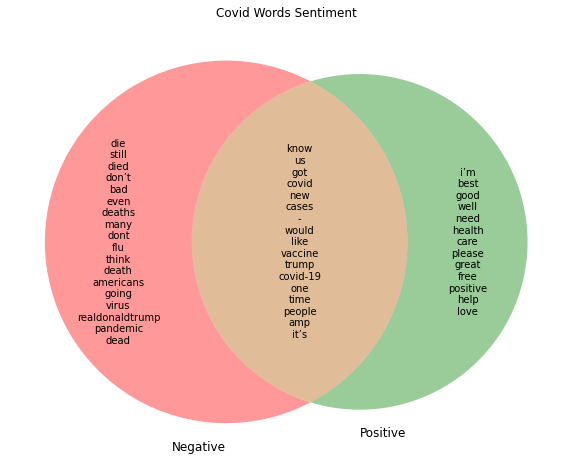

In [210]:
set1 = n
set2 = p

set_covid = n.union(p)

plt.figure(figsize=(10, 10))
venn = venn2([set1, set2], ('Negative', 'Positive'))
venn.get_label_by_id('100').set_text('\n'.join(set1-set2))
venn.get_label_by_id('110').set_text('\n'.join(set1&set2))
venn.get_label_by_id('010').set_text('\n'.join(set2-set1))
plt.title('Covid Words Sentiment')
plt.show()

With word2vec() the most common words inside the two polarized opposite sets are obtained. The results can be seen in the Venn Diagram above. Death and disease are the most incumbent topics (and interestingly also Trump) for the negative side while in the positive side there's a general sense of altruistic sentiment ('care', 'help', 'need', 'thank','please','love' etc.).

In [211]:
df_e_neg = df_e[df_e.polarized_sen == 'negative'].reset_index()
df_e_pos = df_e[df_e.polarized_sen == 'positive'].reset_index()

In [212]:
neg_w2v = Word2Vec(df_e_neg.tweets, min_count= 400)

In [213]:
pos_w2v = Word2Vec(df_e_pos.tweets, min_count= 200)

In [214]:
n = set(list(neg_w2v.wv.vocab))
p = set(list(pos_w2v.wv.vocab))

set_ebola = n.union(p)

common_elements = n.intersection(p) 

In [215]:
ebola_common_neg = n - n.intersection(p)

In [216]:
ebola_common_pos = p - n.intersection(p)

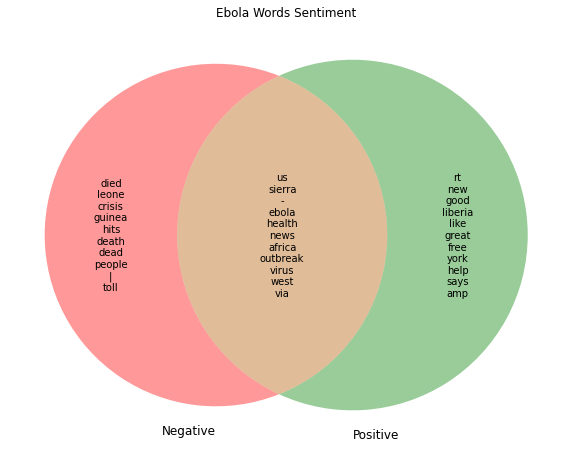

In [217]:
set1 = n
set2 = p

plt.figure(figsize=(10, 10))
venn = venn2([set1, set2], ('Negative','Positive'))
venn.get_label_by_id('100').set_text('\n'.join(set1-set2))
venn.get_label_by_id('110').set_text('\n'.join(set1&set2))
venn.get_label_by_id('010').set_text('\n'.join(set2-set1))
plt.title('Ebola Words Sentiment')
plt.show()

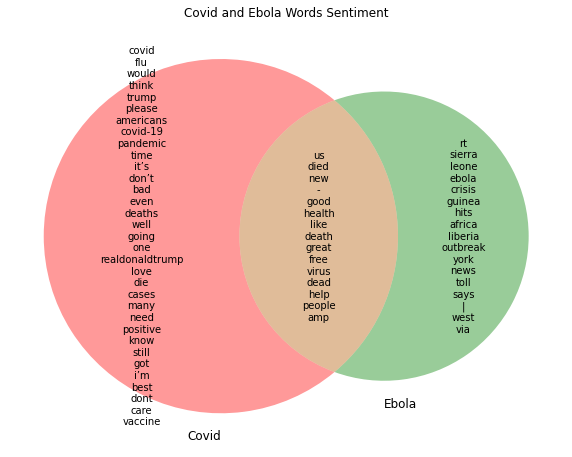

In [218]:
set1 = set_covid
set2 = set_ebola

plt.figure(figsize=(10, 10))
venn = venn2([set1, set2], ('Covid','Ebola'))
venn.get_label_by_id('100').set_text('\n'.join(set1-set2))
venn.get_label_by_id('110').set_text('\n'.join(set1&set2))
venn.get_label_by_id('010').set_text('\n'.join(set2-set1))
plt.title('Covid and Ebola Words Sentiment')
plt.show()



Also, it might be interesting to explore the overall difference in length between positive and negative tweets.

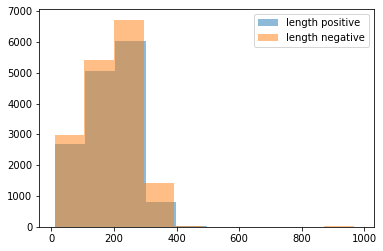

In [219]:
df_c_neg['length'] = [len(i) for i in df_c_neg.tweet]
df_c_pos['length'] = [len(i) for i in df_c_pos.tweet]

plt.hist(df_c_pos.length, label = 'length positive',alpha = 0.5)
plt.hist(df_c_neg.length, label = 'length negative', alpha = 0.5)
plt.legend(loc='upper right')
plt.show()

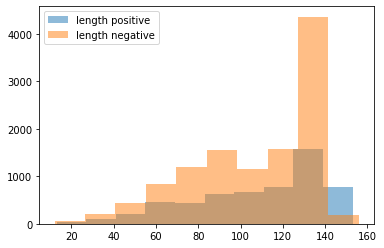

<Figure size 720x720 with 0 Axes>

In [220]:
df_e_neg['length'] = [len(i) for i in df_e_neg.tweet]
df_e_pos['length'] = [len(i) for i in df_e_pos.tweet]

plt.hist(df_e_pos.length, label = 'length positive',alpha = 0.5)
plt.hist(df_e_neg.length, label = 'length negative', alpha = 0.5)
plt.legend(loc='upper left')
plt.figure(figsize=(10, 10))
plt.show()

Both for covid and ebola, there's a pattern showing longer tweets for negative sentiment. This pattern is clear for ebola-related tweets and only slightly confirmed by covid-related ones.

In [221]:
import wordcloud

<Figure size 432x288 with 0 Axes>

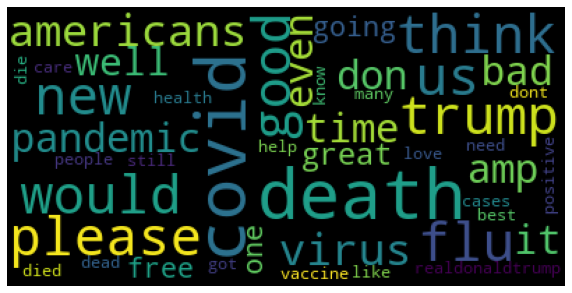

In [222]:
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=50, stopwords = ['dict_keys','-'])
wc = wc.generate(str(",".join(set_covid)))
fig = plt.figure(num=10)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wc)
plt.show()

<Figure size 432x288 with 0 Axes>

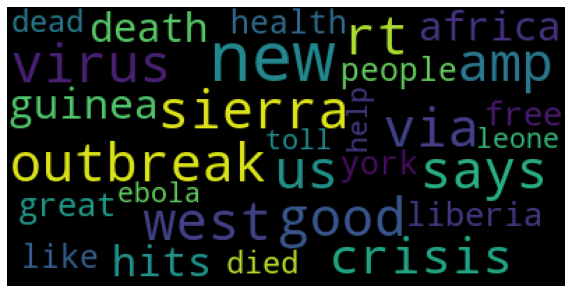

In [223]:
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=50, stopwords = ['dict_keys', '|'], )
wc = wc.generate(str(",".join(set_ebola)))
fig = plt.figure(num=1)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wc)
plt.show()

**Word Embedding**

Word Embedding through a Principal Component Analysis model

In [224]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [225]:
covid_w2v = Word2Vec(df_c.tweets, min_count = 1500)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


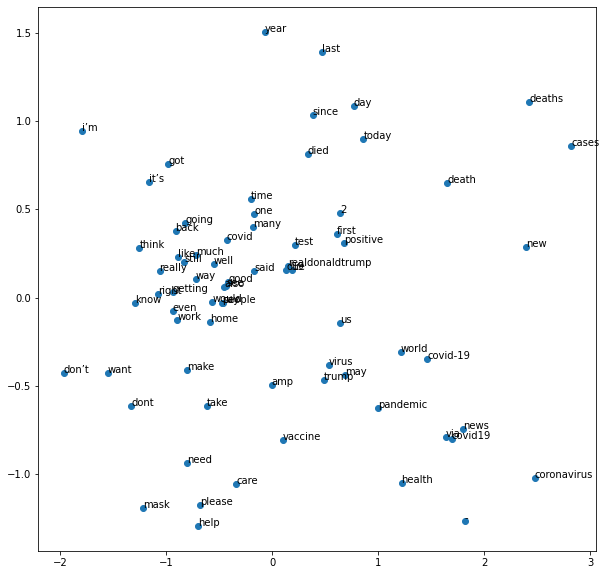

In [226]:
X = covid_w2v[covid_w2v.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
plt.figure(figsize=(10, 10))
plt.scatter(result[:,0], result[:,1])
words = list(covid_w2v.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i,0], result[i,1]))
plt.show()

In [227]:
ebola_w2v = Word2Vec(df_e.tweets, min_count = 1200)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


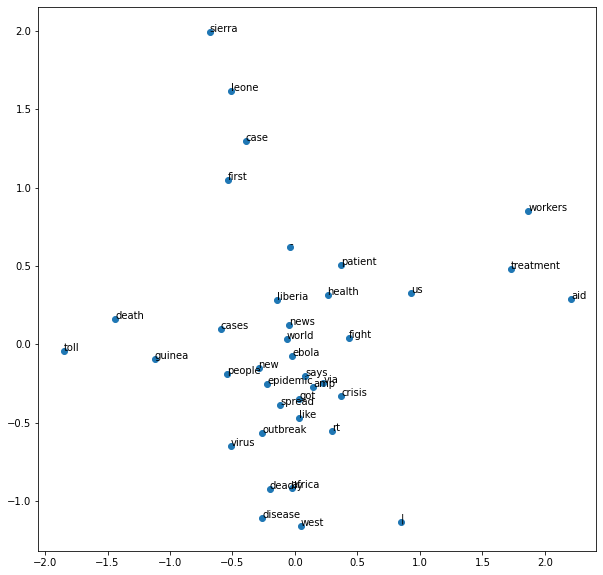

In [228]:
X = ebola_w2v[ebola_w2v.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
plt.figure(figsize=(10, 10))
plt.scatter(result[:,0], result[:,1])
words = list(ebola_w2v.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i,0], result[i,1]))
plt.show()

## Introducing more articulated emotions

When dealing with a pandemic event, the distinction of sentiment only based on 'positive', 'negative', or'neutral' sentiment may be restrictive. It might be interesting to investigate more articulated emotions of tweets, and in this section this kind of investigation will be performed.


NRLLex is a package trough which more articulated sentiments can be obtained. In particular, the emotions of:

- Trust
- Fear
- Anticipation
- Anger
- Joy
- Sadness
- Disgust
- Surprise

are recognised and assigned a number from 0 to 1 based on the polarity of the emotion. There may be several emotions representing a tweet, with the sum of ther polarities being equal to 1.

For covid analysis, 5 main periods have been identified. 
Their labels are, obviously, broad approximations of reality that don't take into account singular states/regions/continents situations. 

- 1/01/2020 - 29/02/2020  : initial period, news spreading
- 1/03/2020 - 31/05/2020  : lockdown
- 1/06/2020 - 30/09/2020  : rules/laws softening
- 1/10/2020 - 31/01/2021  : new emergency
- 1/02/2021 - 30/06/2021  : vaccine campaigns

A sentiment analysis and a keywords analysis based on those 5 periods is performed in order to evaluate relevant differences. 

In [229]:
!pip install NRCLex

In [230]:
from nrclex import NRCLex
from collections import Counter
nltk.download('punkt')
from datetime import datetime

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Covid**

Two functions have been created to retrieve the emotions for each tweet.

- getEmotion( ) returns a dictionary where emotions and corresponding frequencies of each tweet are stored.

- EmotionSummary( ) returns a dictionary with the overall sum of frequencies of each emotion.


In [231]:
def getEmotion(sentence):
  emotion = NRCLex(sentence) 
  a_l = emotion.affect_frequencies
  return a_l

def EmotionSummary(list):
  emotions = [getEmotion(i) for i in list]
  c = Counter()
  for d in emotions:
    c.update(d)
  c = dict(c)
  c = dict(sorted(c.items(), key=lambda item: item[1], reverse=True))
  c.pop('negative')   
  c.pop('positive')
  c.pop('anticip')
  return c

In [232]:
df_c.date = pd.to_datetime(df_c.date)

In [233]:
covid_p1 = df_c[df_c.date < datetime(2020,2,29)]
emotion_sum1 = EmotionSummary(covid_p1.tweet)

In [234]:
covid_p2 = df_c[df_c.date < datetime(2020,5,31)].drop(covid_p1.index)
emotion_sum2 = EmotionSummary(covid_p2.tweet)

In [235]:
covid_p3 = df_c[df_c.date < datetime(2020,9,30)].drop(covid_p2.index).drop(covid_p1.index)
emotion_sum3 = EmotionSummary(covid_p3.tweet)

In [236]:
covid_p4 = df_c[df_c.date < datetime(2021,1,31)].drop(covid_p3.index).drop(covid_p2.index).drop(covid_p1.index)
emotion_sum4 = EmotionSummary(covid_p4.tweet)

In [237]:
covid_p5 = df_c[df_c.date < datetime(2021,6,30)].drop(covid_p4.index).drop(covid_p3.index).drop(covid_p2.index).drop(covid_p1.index)
emotion_sum5 = EmotionSummary(covid_p5.tweet)

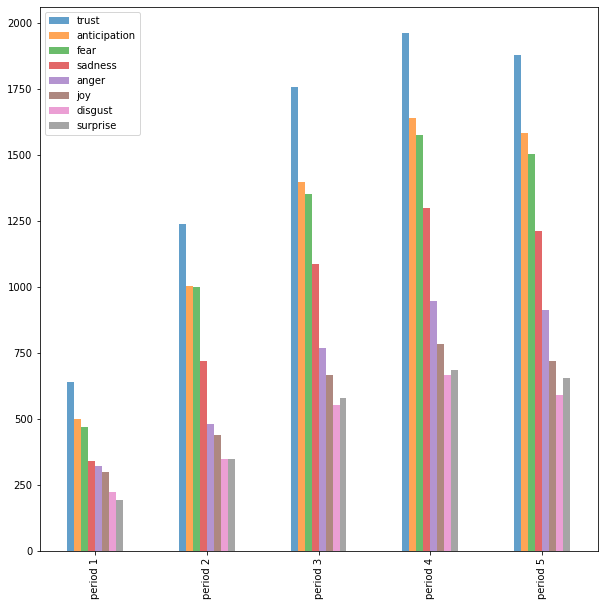

In [238]:
a = pd.DataFrame({'period 1': emotion_sum1,
             'period 2': emotion_sum2,
             'period 3': emotion_sum3,
             'period 4': emotion_sum4,
             'period 5': emotion_sum5})
a = a.transpose()
a.plot.bar(figsize=(10,10), alpha = 0.7)

There are not many differences among periods for what concerns prevalent emotions. 

trust, anticipation and fear are the most frequent ones.  

In [239]:
a = [ covid_p1,covid_p2,covid_p3, covid_p4, covid_p5]

p1_w2v = Word2Vec(covid_p1.tweets, min_count = 250)
p1 = set(p1_w2v.wv.vocab)

p2_w2v = Word2Vec(covid_p2.tweets, min_count = 600)
p2 = set(p2_w2v.wv.vocab)

p3_w2v = Word2Vec(covid_p3.tweets, min_count = 1000)
p3 = set(p3_w2v.wv.vocab)

p4_w2v = Word2Vec(covid_p4.tweets, min_count = 1000)
p4 = set(p4_w2v.wv.vocab)

p5_w2v = Word2Vec(covid_p5.tweets, min_count = 1000)
p5 = set(p5_w2v.wv.vocab)


p1.intersection(p2).intersection(p3).intersection(p4).intersection(p5)
p1-p1.intersection(p2).intersection(p3).intersection(p4).intersection(p5)
p2-p1.intersection(p2).intersection(p3).intersection(p4).intersection(p5)
p3-p1.intersection(p2).intersection(p3).intersection(p4).intersection(p5)
p4-p1.intersection(p2).intersection(p3).intersection(p4).intersection(p5)
p5-p1.intersection(p2).intersection(p3).intersection(p4).intersection(p5)

{'amp', 'cases', 'got', 'new', 'one', 'vaccine'}

- common words to all the periods: 

        ('covid', 'covid-19', 'like', 'people')

- mainly 1st period: 

        ('china', 'health', 'live', 'virus')

- mainly 2nd and 3rd period:

        ('amp','deaths', 'cases', 'new', 'trump')

- mainly 4th and 5th period:

        ('vaccine') 






**Ebola**

In [240]:
ebola_emotion_sum = EmotionSummary(df_e.tweet)

<BarContainer object of 8 artists>

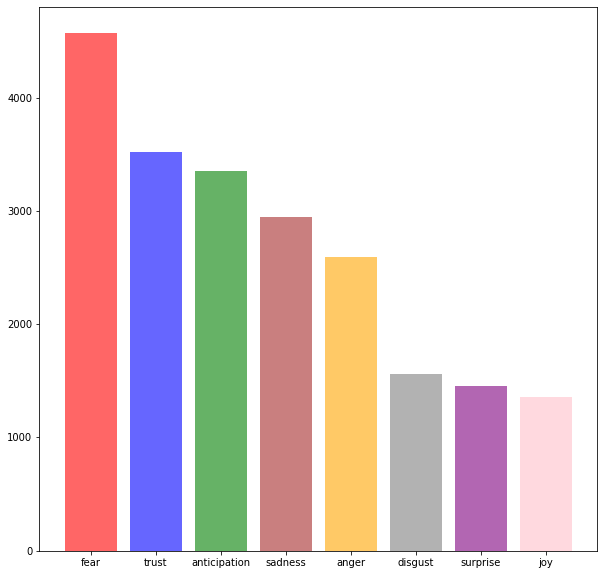

In [241]:
plt.figure(figsize=(10,10))
plt.bar(ebola_emotion_sum.keys(), ebola_emotion_sum.values(), color = ['red','blue', 'green', 'brown', 'orange','grey','purple', 'pink'], alpha = 0.6)

For ebola analysis data haven't been divided into periods but only general emotion analysis has been computed. 

In this case, fear is clearly the most present sentiment, followed by trust, anticipation and sadness. 

The first five emotions, regardless the rank, are the same both for ebola and covid and might be considered the 5 emotions associated with a pandemic outbreak.

## References

- Xue, J., Chen, J., Hu, R., Chen, C., Zheng, C., Su, Y., Zhu, T., *Twitter Discussions and Emotions About the COVID-19 Pandemic: Machine Learning Approach*, J Med Internet Res. 2020 Nov 25;22(11):e20550. doi: 10.2196/20550. PMID: 33119535; PMCID: PMC7690968. 

- Liang, H., Fung, I.CH., Tse, Z.T.H. et al., 2019, *How did Ebola information spread on twitter: broadcasting or viral spreading?*, BMC Public Health 19, 438 (2019). https://doi.org/10.1186/s12889-019-6747-8 

- VanderPlas, J., 2016, *Python Data Science Handbook: Essential Tools for Working with Data*, O'Reilly. 

